In [1]:
import numpy as np
import matplotlib.pyplot as plt
from pymcaspec import specfile

%matplotlib inline

## Proceedure for estimate penetration depth

Take XAS measured in TEY on La_2CuO_4 from M.P.M. Dean et al., Nature Materials 12, 1019–1023 (2013) 

Compute XAS for La_2CuO_4 Density=7.0, Angle=90.deg using
http://henke.lbl.gov/tmp/xray6982.dat

The computed values are accurate for the pre- and post- edge values correctly, but does not account for the resonance.

We, therefore, scale the pre and post edge of the experiment to the table values and read-off the values at the peak.

Penetration depth at peak 238.7 nm


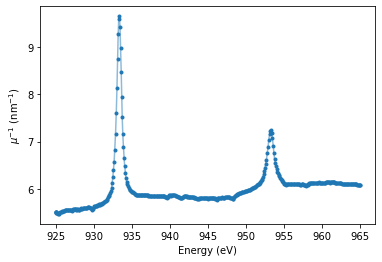

In [2]:
F = specfile("one_XAS_scan.spec")
S = F[595]

E = S['ene_st']
TEY = S['zratio']

pre = 1/0.182946
post = 1/ 0.164596

x = E
y = TEY - np.min(TEY)
y = y / np.mean(y[-1:]) * (post-pre)
mu = y + pre



fig, ax = plt.subplots()
art, *_ = ax.plot(x, mu, '-', alpha=0.5)
ax.plot(x, mu, '.', color=art.get_color())
ax.set_xlabel("Energy (eV)")
ax.set_ylabel(r"$\mu^{-1}$ (nm$^{-1}$)")

print("Penetration depth at peak {:.1f} nm".format(1000/y.max()))

## Estimate of core hole lifetime

[[Model]]
    (Model(lorentzian) + Model(constant))
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 54
    # data points      = 45
    # variables        = 4
    chi-square         = 0.13092824
    reduced chi-square = 0.00319337
    Akaike info crit   = -254.789576
    Bayesian info crit = -247.562926
[[Variables]]
    amplitude:  4.89198034 +/- 0.06854140 (1.40%) (init = 1)
    center:     933.299413 +/- 0.00269276 (0.00%) (init = 933)
    sigma:      0.37733195 +/- 0.00549841 (1.46%) (init = 1)
    c:          5.59931704 +/- 0.01614723 (0.29%) (init = 6.7)
    fwhm:       0.75466390 +/- 0.01099682 (1.46%) == '2.0000000*sigma'
    height:     4.12677955 +/- 0.03060451 (0.74%) == '0.3183099*amplitude/max(2.220446049250313e-16, sigma)'
[[Correlations]] (unreported correlations are < 0.100)
    C(amplitude, sigma) =  0.866
    C(amplitude, c)     = -0.849
    C(sigma, c)         = -0.691


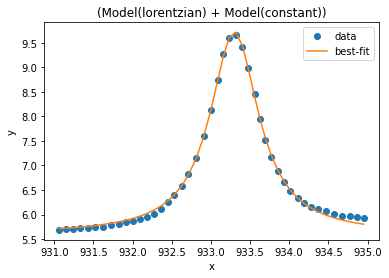

In [3]:
## fit main peak
choose = np.logical_and(x>931, x<935)
xx = x[choose]
yy = mu[choose]

fig, ax = plt.subplots()

from lmfit.models import LorentzianModel, ConstantModel

model = LorentzianModel() + ConstantModel()
params = model.make_params(c=6.7, center=933)
result = model.fit(yy, x=xx, params=params)

result.plot_fit(ax=ax)

print(result.fit_report())

In [4]:
print(f"Half-width at half maximum is {result.best_values['sigma']:.2f} eV")

Half-width at half maximum is 0.38 eV


## Self absorption / saturation effects in TFY
Measuring XAS with TFY is subject to self absorption / saturation effects. Here we present a simple method to correct this.

Using $\alpha$ and $\beta$ as incident and scattered x-ray angles w.r.t surface, and taking eq. 2 from [here](https://markdean.info/assets/pdf/Dashwood2021probing_supp.pdf) assuming that the x-ray come out at energies below the edge, we arrive at a crude esimate for the self absorption corrected data.



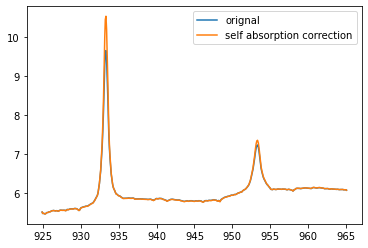

In [5]:
TFY = mu # Take fake data from here
alpha = 30
beta = 30

def sind(theta):
    return np.sin(theta*np.pi/180)

angular_ratio = sind(alpha)/sind(beta)

C = 1/(1 + angular_ratio*mu/pre)

mu_corr = TFY/C
mu_corr -= mu_corr.min()
mu_corr = mu_corr / mu_corr[-1] * (post-pre)
mu_corr = mu_corr + pre


fig, ax = plt.subplots()
ax.plot(x, mu, label='orignal')
ax.plot(x, mu_corr, label='self absorption correction')
ax.legend()